# Uplift model

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import warnings
import os

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:
## Read data
path = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/customer_banking/uplifting_model/Dataset/bank-full.csv'
dataset = pd.read_csv(path,sep = ';')

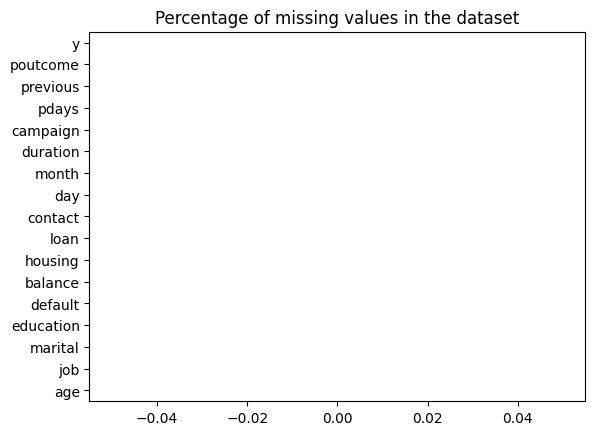

In [3]:
## Percentage of missing values
dataset.isna().mean().plot(kind = 'barh')
plt.title('Percentage of missing values in the dataset')
plt.show()

In [4]:
dataset['poutcome'].value_counts()

poutcome
unknown    36959
failure     4901
other       1840
success     1511
Name: count, dtype: int64

## Uplifting

In [5]:
### Only previous successess
only_success = dataset[dataset['poutcome'] == 'success']
only_failures = dataset[dataset['poutcome'] == 'failure']


In [6]:
### Model for previous successes

x_success = only_success.drop('y', axis = 1)
y_success = only_success['y']

x_train, x_test, y_train, y_test = train_test_split(x_success, y_success, test_size = 0.2, random_state = 123)

In [10]:
VARS = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'loan',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous'
    ]
CAT_VARS = [
    'job',
    'marital',
    'education',
    'housing',
    'loan',
    'contact',
    'month'
    ]

train_pool = Pool(x_train[VARS], y_train, cat_features = CAT_VARS)
params = {
    "iterations": 1000,
    "depth": 5,
    "loss_function": "Logloss",
    "roc_file": "roc-file"
          }
scores = cv(train_pool, fold_count=5, params = params, verbose=False)

Training on fold [0/5]

bestTest = 0.5058099406
bestIteration = 446

Training on fold [1/5]

bestTest = 0.5377802681
bestIteration = 479

Training on fold [2/5]

bestTest = 0.5661851285
bestIteration = 382

Training on fold [3/5]

bestTest = 0.5371759993
bestIteration = 377

Training on fold [4/5]

bestTest = 0.5262496787
bestIteration = 295



In [19]:
model = CatBoostClassifier(iterations = 1000, depth = 5, loss_function = 'Logloss')
model.fit(train_pool, verbose = False)
preds = model.predict(x_test[VARS])
probas = model.predict_proba(x_test[VARS])

In [21]:
accuracy_score(y_test, preds)
roc_auc_score(y_test, probas[:,1])

0.7054251434533124